# 損失関数

## 回帰 Regression

### 二乗損失

:::{admonition} 二乗損失 (Squared Loss)

観測値 $y$、予測値 $\hat y$、残差 $e = y - \hat y$ とおくと

$$
L_{\text{Squared}}(e) = \frac{1}{2} e^2
= \frac{1}{2} (y - \hat{y})^2
$$

:::

誤差を二乗するので、絶対誤差に比べて大きく予測を外した値が強調されるのが特徴。

$\frac{1}{2}$を乗じているのは微分したときに簡潔に示すため。

:::{card} 二乗誤差の勾配

$$
\frac{\partial L_{\text{Squared}}}{\partial e} = e = y - \hat{y}
$$

:::

### 絶対損失

二乗しないため外れ値に強い（外れ値の予測誤差を比較的小さく評価する）。

:::{admonition} 絶対損失 (Absolute Loss)

$$
L_{\text{Absolute}}(e) = |e| = |y - \hat{y}|
$$

:::


**勾配**

$e = 0$ では微分が定義されないため、**劣勾配（subgradient）** として区間 $[-1, 1]$ を取る

$$
\frac{\partial L_{\text{Absolute}}}{\partial e} =
\begin{cases}
+1 & (e > 0) \\
-1 & (e < 0) \\
[-1,\,1] & (e = 0)
\end{cases}
$$

実装上は多くの場合、$\frac{\partial L}{\partial e} = \mathrm{sign}(e)$  とし、$e = 0$ の場合は $0$ を返すことが多い

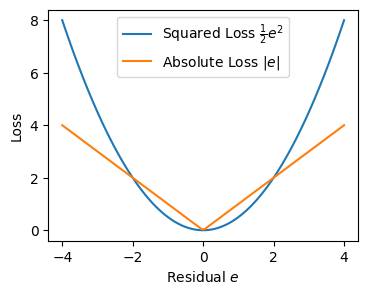

In [11]:
import matplotlib.pyplot as plt
import numpy as np

e = np.linspace(-4, 4, 100)

plt.figure(figsize=[4, 3])
plt.plot(e, (1/2) * e**2, label=r"Squared Loss $\frac{1}{2}e^2$")
plt.plot(e, abs(e), label=r"Absolute Loss $|e|$")

plt.ylabel("Loss")
plt.xlabel(r"Residual $e$")
plt.legend()
plt.show()

### Huber Loss

絶対損失がゼロ付近で微分不可能である問題に対処し、ある閾値$\delta$未満の誤差（ $|e| \le \delta$ ）のときだけ二乗損失にしたもの。

:::{admonition} Huber Loss

観測値 $y$、予測値 $\hat y$、残差 $e = y - \hat y$、しきい値 $\delta > 0$ とすると、

$$
L_{\text{Huber}}(e)=
\begin{cases}
\frac{1}{2} e^2 & (|e| \le \delta) \\\\
\delta \left(|e| - \frac{1}{2}\delta\right) & (|e| > \delta)
\end{cases}
$$

:::

勾配

$$
\frac{\partial L_{\text{Huber}}}{\partial e} =
\begin{cases}
e & (|e| \le \delta) \\\\
\delta \cdot \mathrm{sign}(e) & (|e| > \delta)
\end{cases}
$$



### Fair loss

**Fair loss** は、残差が大きくなるにつれて影響を連続的になだらかに抑制するロバスト損失関数である。  
Huber loss のような明確な折れ点を持たず、全域で滑らかな形状を持つ。

:::{admonition} Fair Loss

スケールパラメータ $c > 0$、残差 $e = y - \hat y$ とすると、

$$
L_{\text{Fair}}(e)
=
c^2 \left(
\frac{|e|}{c}
-
\log\left(1 + \frac{|e|}{c}\right)
\right)
$$

:::


**勾配**

$$
\frac{\partial L_{\text{Fair}}}{\partial e}
=
\frac{e}{1 + |e|/c}
$$


**特徴**

- 小さな残差では二乗誤差に近い挙動
- 残差が大きくなるにつれて勾配が連続的に減衰
- 全域で滑らか（高階微分も連続）
- 非常に大きな外れ値に対しても安定


**利用場面**
- 外れ値が多い、または裾の重い分布を持つデータ
- 勾配ベース最適化で数値安定性を重視する場合
- Huber loss よりも強いロバスト性が必要なケース


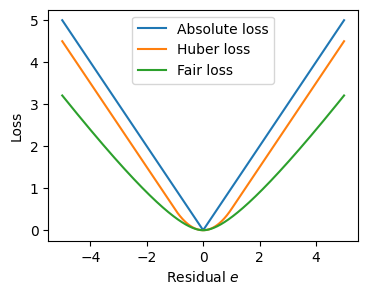

In [14]:
import matplotlib.pyplot as plt
import numpy as np

e = np.linspace(-5, 5, 1000)
# parameters
delta = 1.0
c = 1.0
# Huber loss
huber = np.where(
    np.abs(e) <= delta,
    0.5 * e**2,
    delta * (np.abs(e) - 0.5 * delta)
)
# Fair loss
fair = c**2 * (np.abs(e) / c - np.log(1 + np.abs(e) / c))

plt.figure(figsize=[4,3])

plt.plot(e, abs(e), label=r"Absolute loss")
plt.plot(e, huber, label="Huber loss")
plt.plot(e, fair, label="Fair loss")
plt.xlabel("Residual $e$")
plt.ylabel("Loss")
plt.legend()
plt.show()

:::{admonition} MAPEの最適化にFair Loss
:class: info

MAPEは絶対誤差（MAE）に似ているが、絶対損失だと勾配をとったときに残差の符号しか残らず、誤差の大きさがわからなくなる。  
その点、Fair Lossのほうがいいらしい。

（参考：[SIGNATE 土地価格コンペ 1位解法](https://user.competition.signate.jp/ja/competition/detail/?competition=58de9c02714149c78d056b0f76958356&task=401f2756b9d1471c9ba9ce78f1adcd2e&tab=knowledge&knowledge=6c093e1038fa4b2d82535aef1d924f6f)）

:::

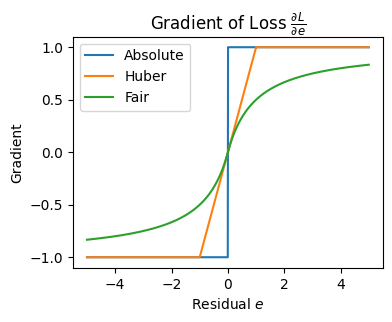

In [18]:
import matplotlib.pyplot as plt
import numpy as np

e = np.linspace(-5, 5, 1000)

# parameters
delta = 1.0
c = 1.0

# gradients

# Absolute loss gradient (subgradient, 0 at e=0)
grad_abs = np.sign(e)

# Huber loss gradient
grad_huber = np.where(
    np.abs(e) <= delta,
    e,
    delta * np.sign(e)
)

# Fair loss gradient
grad_fair = e / (1 + np.abs(e) / c)

# plot
plt.figure(figsize=(4, 3))
plt.title(r"Gradient of Loss $\frac{\partial L}{\partial e}$")
plt.plot(e, grad_abs, label=r"Absolute")
plt.plot(e, grad_huber, label="Huber")
plt.plot(e, grad_fair, label="Fair")
plt.xlabel("Residual $e$")
plt.ylabel("Gradient")
plt.legend()
plt.show()

## 確率予測

### Log Loss（Cross Entropy Loss）

予測確率の信頼度を含めた誤差指標。確率出力モデルに適する。  

$$
\text{LogLoss} = -\frac{1}{n}\sum_{i=1}^n [y_i\log \hat{p}_i + (1-y_i)\log(1-\hat{p}_i)]
$$
